## Data 620 - Final Project
### Fall 2017
#### Liam Byrne and Dmitriy Vecheruk
***
### Bitcoin Trading Price and Natural Language Processing

The value of cryptocurrencies, mainly Bitcoin ([BTC](https://coinmarketcap.com/currencies/bitcoin/)), have been extremely volatile since their inception. This volatility is spurred mainly by speculation, rumors and headlines. It would be an interesting use case of Natural Language Processing (NLP) to see how the cryptocurrency markets respond to news, rumor and overall sentiment; let's encapsulate all of these into sentiment for the sake of clarity. The result could be a gradation of the following:

1. Markets react to sentiment - *possible to capitalize on*
2. Sentiment is a reaction to the markets - *no use to capitalize on*
3. There is no correlation to either - *no use to capitalize on*

Moving forward, we will assume that **(1)** from above is how the markets react. In order to analyze this hypothesis, trading price form 

Found this Stackoverflow thread:  
>Actually, you CAN get the whole Bitcoin trades history from Bitcoincharts in CSV format here : > http://api.bitcoincharts.com/v1/csv/

>it is updated twice a day for active exchanges, and there is a few dead exchanges, too.

>EDIT: Since there are no column headers in the CSVs, here's what they are : column 1) the trade's names=None, column 2) the price, column 3) the volume of the trade

  
Downloaded the data for bitstampUSD: 724 Mb unzipped csv.
Let's try

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
#import autopep8 # Could not get running --> Liam

In [2]:
# Matplotlib setup
from __future__ import print_function, division
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Plotly setup
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly import tools

# Make plotly work with Jupyter notebook
init_notebook_mode(connected=True)

In [4]:
# Run once to fetch the data and filter it to 2017 only

# ADD CONDITION IF ISPATH to skip over this block

# Add the code to download and unzip the data from this URL:

# http://api.bitcoincharts.com/v1/csv/bitstampUSD.csv.gz (this is the 724Mb file)


# inp = pd.read_csv("data/bitstampUSD.csv",names = ["timestamp","price", "volume"])

# inp["date_time"]= pd.to_datetime(inp["timestamp"], unit='s')\
#                  .dt.tz_localize('UTC')\
#                  .dt.tz_convert('America/New_York')
        
# btc = inp[inp["date_time"]>= "2017-01-01"]
# btc.to_csv("processed_data/bitstampUSD_processed_2017.csv",index=False)
# btc.to_pickle("processed_data/bitstampUSD_processed_2017.p")

In [5]:
#Changed file extension form .p to .pkl --> Liam
processed_path = "processed_data/bitstampUSD_processed_2017.pkl"
btc = pd.read_pickle(processed_path)

In [6]:
btc.head()
# btc.dtypes

,timestamp,price,volume,date_time
10935934,1491004831,1071.34,0.010045,2017-03-31 20:00:31-04:00
10935935,1491004831,1071.34,0.019382,2017-03-31 20:00:31-04:00
10935936,1491004852,1070.53,0.029280,2017-03-31 20:00:52-04:00
10935937,1491004856,1070.31,0.108770,2017-03-31 20:00:56-04:00
10935938,1491004872,1070.93,0.200000,2017-03-31 20:01:12-04:00


In [7]:
# Extract the date, add date time to index and cut out the end of 2016 
btc["date"] = btc.date_time.dt.date
btc.index = btc.date_time
btc = btc["2017"]

#### How did the price development look like in 2017?

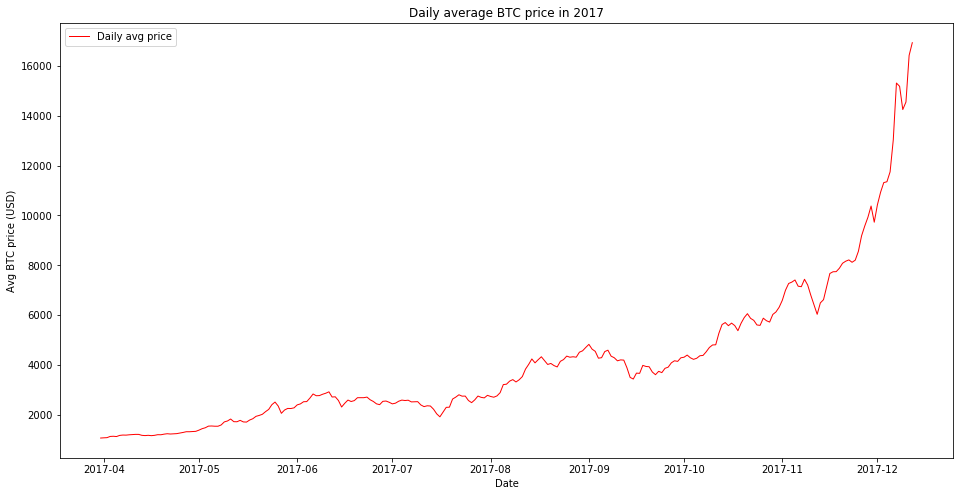

In [8]:
# Make the daily/hourly plot
btc = btc.sort_values("timestamp")
df = btc.groupby("date")["price"].agg(['mean']).rename(columns={'mean': 'price'})

plt.figure(num=1, figsize=(16, 8)) 
plt.plot(df.index, df["price"], linewidth=1,
         color="red", label=r"Daily avg price")
plt.xlabel(r"Date")
plt.ylabel(r"Avg BTC price (USD)")
plt.title(r"Daily average BTC price in 2017")


plt.legend(loc="upper left")

plt.show()

#### Did the price increase or decrease at the close of the day?

In [9]:
# Add the time aggregation and OHLC funciton


def time_precision(series, precision):
    """
    Returns the date time series with a date time value floored to the 
    specified freq string
    """
    return (pd.DatetimeIndex(series)).floor(precision)


def make_ohlc(df, datetime_col, price_col, time_granularity):
    """
    Calculates the data for an OHLC chart from a df with a date_time and
    price columns, with intervals of time_granularity. Returns a DataFrame.
    """
    
    df = df.sort_values(datetime_col)    
    df["time_bracket"] = df[datetime_col].map(
        lambda x: time_precision(x, time_granularity))

    btc_ohlc = df.groupby("time_bracket")[price_col]\
        .agg(["first", "max", "min", "last", "median"])\
        .rename(columns={'first': 'open', 'max': 'high', "min": "low", "last": "close"})

    conditions = [(btc_ohlc['open'] <= btc_ohlc['close']),
                  (btc_ohlc['open'] > btc_ohlc['close'])]

    choices = ["up", "down"]

    btc_ohlc['price_change_label'] = np.select(conditions, choices)

    btc_ohlc["price_change_pct"] = 100 * \
        (btc_ohlc["close"] / btc_ohlc["open"] - 1)

    return (btc_ohlc)

In [10]:
btc_ohlc_24h = make_ohlc(btc,"date_time","price","1d")
btc_ohlc_6h = make_ohlc(btc,"date_time","price","6h")

In [11]:
btc_ohlc_6h.head(5)

,open,high,low,close,median,price_change_label,price_change_pct
time_bracket,,,,,,,
2017-03-31 18:00:00-04:00,1071.34,1076.84,1065.61,1069.15,1070.150,down,-0.204417
2017-04-01 00:00:00-04:00,1069.15,1096.99,1065.50,1089.16,1076.180,up,1.871580
2017-04-01 06:00:00-04:00,1087.85,1097.00,1065.64,1073.65,1089.925,down,-1.305327
2017-04-01 12:00:00-04:00,1073.68,1076.90,1061.64,1072.13,1069.990,down,-0.144363
2017-04-01 18:00:00-04:00,1072.53,1085.00,1072.47,1074.77,1077.830,up,0.208852


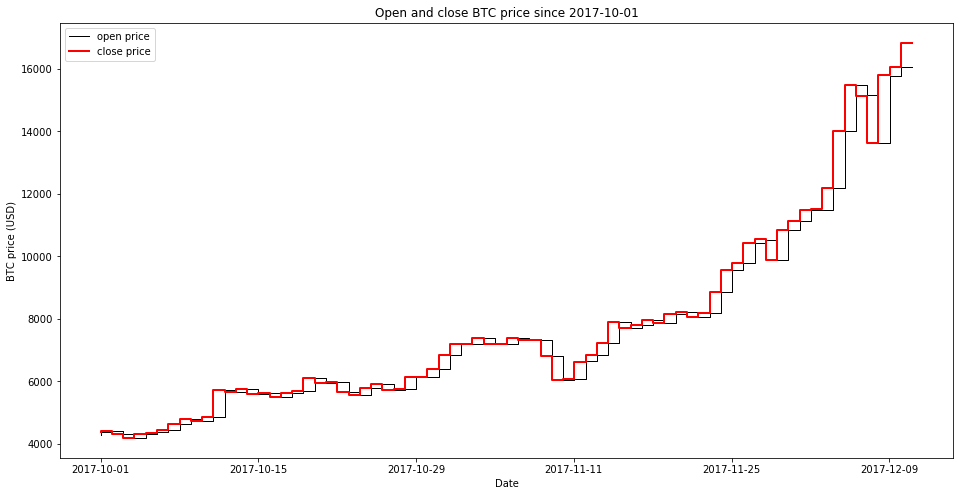

In [12]:
# Make the o-c plot
start_date = "2017-10-01"
df = btc_ohlc_24h[pd.to_datetime(start_date).date():]

plt.figure(num=1, figsize=(16, 8)) 
plt.step(df.index, df["open"], linewidth=1,
         color="black", label=r"open price")
plt.xlabel(r"Date")
plt.ylabel(r"BTC price (USD)")
plt.title(r"Open and close BTC price since "+start_date)
plt.step(df.index, df["close"], linewidth=2,
         color="red", label=r"close price")
plt.legend(loc="upper left")
plt.show()

In [14]:
start_date = "2017-06-01"
df = btc_ohlc_24h[pd.to_datetime(start_date).date():]

trace = go.Ohlc(x=df.index,
                open=df.open,
                high=df.high,
                low=df.low,
                close=df.close,
               name = "BTC price")
data = [trace]
layout = dict(title = "Daily BTC price changes since "+start_date,
              yaxis = {'title': 'BTC Price USD'},legend=dict(orientation="h"))
fig = dict(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

In [15]:
btc_ohlc_24h.groupby("price_change_label")["price_change_label"].count()

price_change_label
down     99
up      158
Name: price_change_label, dtype: int64

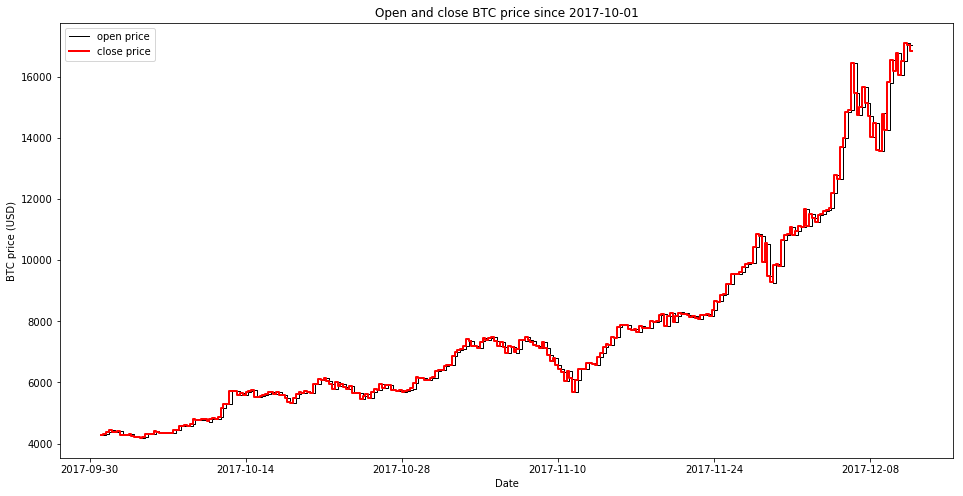

In [16]:
# Make the o-c plot
start_date = "2017-10-01"
df = btc_ohlc_6h[pd.to_datetime(start_date).date():]

plt.figure(num=1, figsize=(16, 8)) 
plt.step(df.index, df["open"], linewidth=1,
         color="black", label=r"open price")
plt.xlabel(r"Date")
plt.ylabel(r"BTC price (USD)")
plt.title(r"Open and close BTC price since "+start_date)
plt.step(df.index, df["close"], linewidth=2,
         color="red", label=r"close price")
plt.legend(loc="upper left")
plt.show()

In [17]:
btc_ohlc_24h.to_csv("processed_data/btc_ohlc_24.csv")
btc_ohlc_6h.to_csv("processed_data/btc_ohlc_6h.csv")

## The time aggregated DF used later for joining with Twitter is defined here:

In [18]:
time_aggr = "12h" ## Definition of the used time precision!
btc_ohlc = make_ohlc(btc,"date_time","price",time_aggr)

In [19]:
btc_ohlc.head(5)

,open,high,low,close,median,price_change_label,price_change_pct
time_bracket,,,,,,,
2017-03-31 12:00:00-04:00,1071.34,1076.84,1065.61,1069.15,1070.15,down,-0.204417
2017-04-01 00:00:00-04:00,1069.15,1097.00,1065.50,1073.65,1083.74,up,0.420895
2017-04-01 12:00:00-04:00,1073.68,1085.00,1061.64,1074.77,1073.04,up,0.101520
2017-04-02 00:00:00-04:00,1074.77,1089.00,1066.49,1089.00,1076.58,up,1.324004
2017-04-02 12:00:00-04:00,1089.00,1120.50,1071.12,1120.50,1088.00,up,2.892562


### Get the Tweets

In [20]:
# Previous file used was "data/tweets2017.csv"
twt_path = "data/tweetnews_2017.csv"
twt = pd.read_csv(twt_path, encoding = "ISO-8859-1")
twt.shape

(182789, 2)

In [21]:
twt.head()

,tweet,timestamp
0,#loveit #bitcoin #journalism https://www. ther...,2017-04-01 19:55:25
1,Is Ethereum The New Bitcoin ? http:// huff.to/...,2017-04-01 19:40:01
2,????????????? ??????? http://www. nikkei.com/a...,2017-04-01 19:27:41
3,"#btc Bill OReilly Thrives at Fox News, Even a...",2017-04-01 19:00:06
4,2.0 - #Blockchain startup Chain teams with Tha...,2017-04-01 18:45:02


Add the tweets sourced from Bitcoin bloggers and finance experts

In [22]:
#twt_path_1 = "data/tweepy_tweets.csv"
#twt_1 = pd.read_csv(twt_path_1)
#twt_1.head(5)

In [23]:
# Union the two datasources
#twt = pd.concat([twt, twt_1],axis=0,ignore_index=True)
#twt.shape

In [24]:
twt = twt.sort_values("timestamp")
twt["timestamp"] = pd.to_datetime(twt["timestamp"])
twt = twt[twt["timestamp"]>= pd.to_datetime("2017-01-01")]
twt.head()

,tweet,timestamp
130,Investment Firm Will Use Bitcoin To Avoid US S...,2017-03-31 20:00:05
129,#Anarchist #Bitcoin Coder Amir Taaki Wound Up ...,2017-03-31 20:28:19
128,????????? Bitcoin ?Monacoin?????? - NAVER ??? ...,2017-03-31 21:04:50
127,How The Technology Behind Bitcoin Is Going To ...,2017-03-31 21:19:49
126,How an Anarchist Bitcoin Coder Found Himself F...,2017-03-31 21:51:09


### Question to clarify - what is the timezone of the twitter timestamps? What is the timezone of the bitcoin price data?

#### Clean the tweets from URLS, non-english characters, and duplicates

In [25]:
def isEnglish(s):
    """Checks if a string contains ASCII characters only.
    Source: https://stackoverflow.com/a/27084708/8066374
    """
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [26]:
# Clean the tweets
twt["tweet_proc"] = twt["tweet"].str.replace("https?://.*","") # remove all urls
twt["tweet_proc"] = twt["tweet_proc"].str.replace("’|#","") # remove non-unicode apostrophe and also hashtag sign
twt = twt[twt["tweet_proc"].str.len() >= 3] # retain only the tweets with more than 3 remaining characters
twt["is_english"] = twt["tweet_proc"].map(isEnglish)

In [27]:
twt.head()

,tweet,timestamp,tweet_proc,is_english
130,Investment Firm Will Use Bitcoin To Avoid US S...,2017-03-31 20:00:05,Investment Firm Will Use Bitcoin To Avoid US S...,True
129,#Anarchist #Bitcoin Coder Amir Taaki Wound Up ...,2017-03-31 20:28:19,Anarchist Bitcoin Coder Amir Taaki Wound Up Fi...,True
128,????????? Bitcoin ?Monacoin?????? - NAVER ??? ...,2017-03-31 21:04:50,????????? Bitcoin ?Monacoin?????? - NAVER ???,True
127,How The Technology Behind Bitcoin Is Going To ...,2017-03-31 21:19:49,How The Technology Behind Bitcoin Is Going To ...,True
126,How an Anarchist Bitcoin Coder Found Himself F...,2017-03-31 21:51:09,How an Anarchist Bitcoin Coder Found Himself F...,True


In [28]:
twt.groupby(["is_english"])["tweet"].count()

is_english
False     32086
True     147268
Name: tweet, dtype: int64

Removed 8404 tweets with non-ascii characters to prepare the data for VADER sentiment analysis

In [29]:
twt_clean = twt[twt["is_english"]==True]

In [30]:
twt_clean = twt_clean.drop_duplicates("tweet_proc")

In [31]:
twt_clean = twt_clean.reset_index(drop = True)
twt_clean.shape

(75338, 4)

Only ~75.3k tweets remain after the cleaning step

#### Extract sentiment using NLTK and VADER

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [33]:
print(twt_clean.tweet_proc[0])
print(sid.polarity_scores(twt_clean.loc[0,'tweet_proc']))

Investment Firm Will Use Bitcoin To Avoid US Sanctions On Iran 
{'neg': 0.18, 'neu': 0.82, 'pos': 0.0, 'compound': -0.296}


In [34]:
twt_clean["sid"] = twt_clean["tweet_proc"].map(lambda x: sid.polarity_scores(x))

In [35]:
twt_clean = pd.concat([twt_clean.drop(["sid","tweet","is_english"], axis=1), 
                       twt_clean["sid"].apply(pd.Series)], axis=1)

In [36]:
pd.Timestamp('2015-11-01 01:00:03').tz_localize( "America/New_York",ambiguous=False).floor(time_aggr)

Timestamp('2015-11-01 00:00:00-0400', tz='America/New_York')

#### Visualize the daily sentiment over time

In [37]:
# Extract time components 
twt_clean["date_time"] = pd.to_datetime(twt_clean["timestamp"])

In [38]:
# Add the time granularity required for the join with the price data
twt_clean["time_bracket"] = (pd.DatetimeIndex(twt_clean["date_time"],
                                              tz = "America/New_York",
                                              ambiguous=False)).floor(time_aggr)

# Get daily total for the VADER scores
twt_clean_agg = twt_clean[["time_bracket","neg","pos","compound"]].groupby(["time_bracket"]).sum()
twt_clean_agg.head()


,neg,pos,compound
time_bracket,,,
2017-03-31 12:00:00-04:00,0.849,0.455,-0.8425
2017-04-01 00:00:00-04:00,3.317,4.314,2.2174
2017-04-01 12:00:00-04:00,1.666,2.809,2.0003
2017-04-02 00:00:00-04:00,1.814,1.901,-0.1822
2017-04-02 12:00:00-04:00,1.685,4.335,4.2585


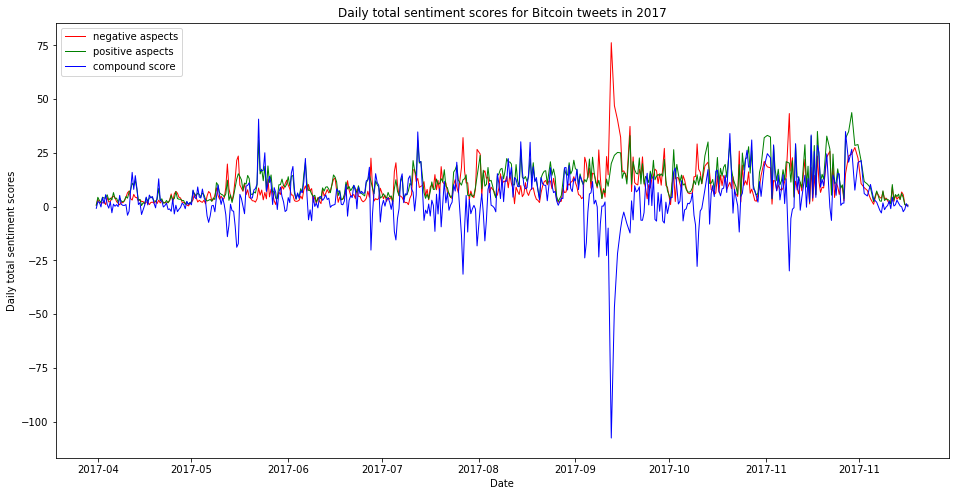

In [39]:
# Make a line plot
df = twt_clean_agg

plt.figure(num=1, figsize=(16, 8)) 
plt.plot(df.index, df["neg"], linewidth=1,
         color="red", label=r"negative aspects")
plt.plot(df.index, df["pos"], linewidth=1,
         color="green", label=r"positive aspects")
plt.plot(df.index, df["compound"], linewidth=1,
         color="blue", label=r"compound score")
plt.xlabel(r"Date")
plt.ylabel(r"Daily total sentiment scores")
plt.title(r"Daily total sentiment scores for Bitcoin tweets in 2017")


# plt.plot(btc_daily_avg["date"], btc_daily_avg["price"], linewidth=1,
#          color="blue", label=r"daily avg price")

plt.legend(loc="upper left")

plt.show()

#### Correlate the daily compound sentiment with the price change direction

In [40]:
# Sentiment differential
twt_clean_agg["sent_diff"] = 0.0

for s in range(1, len(twt_clean_agg.index)):
    twt_clean_agg["sent_diff"][s] = np.float(twt_clean_agg["compound"][s]-twt_clean_agg["compound"][s-1])
    
twt_clean_agg.head()

,neg,pos,compound,sent_diff
time_bracket,,,,
2017-03-31 12:00:00-04:00,0.849,0.455,-0.8425,0.0000
2017-04-01 00:00:00-04:00,3.317,4.314,2.2174,3.0599
2017-04-01 12:00:00-04:00,1.666,2.809,2.0003,-0.2171
2017-04-02 00:00:00-04:00,1.814,1.901,-0.1822,-2.1825
2017-04-02 12:00:00-04:00,1.685,4.335,4.2585,4.4407


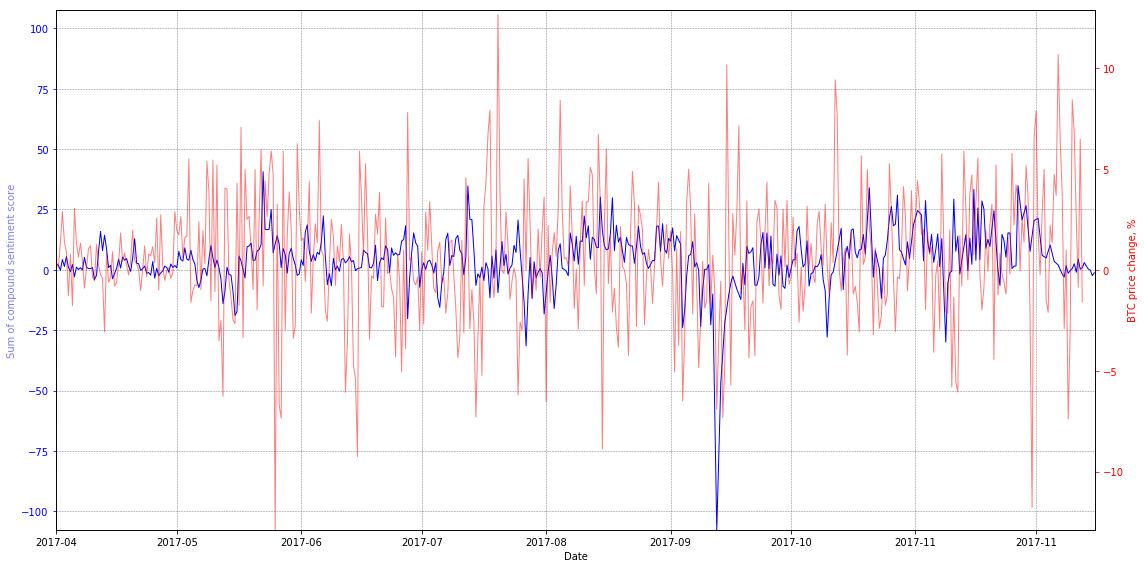

In [42]:
df1 = twt_clean_agg[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

import datetime
#Zoom timeline
format = '%Y-%m-%d %H:%M:%S'
start = datetime.date(2017, 4, 1) #enter 'None' to see all left
end = datetime.date(2017, 12, 16) #enter 'None' to see all right

#Variables
twt_var = "compound"#"sent_diff"
btc_var = "price_change_pct"#close
df1 = df1[(df1.index >= pd.to_datetime(start)) & (df1.index <= pd.to_datetime(end))]
df2 = df2[(df2.index >= pd.to_datetime(start)) & (df2.index <= pd.to_datetime(end))]

#Force same y
twt_lim = max(abs(df1[twt_var]))
btc_lim = max(abs(df2[btc_var]))


fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(df1.index, df1[twt_var], linewidth=1,color="blue")
ax1.set_xlabel('Date')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Sum of compound sentiment score', color='blue', alpha = 0.5)
ax1.tick_params('y', colors='blue')
ax1.grid(color='grey', linestyle='--', linewidth=.5)
ax1.set_ylim(-twt_lim, twt_lim)
ax1.set_xlim(left = start, right = end)
#ax1.set_yscale("log", nonposy='clip')

ax2 = ax1.twinx()

ax2.plot(df2.index, df2[btc_var], linewidth=1,color="red", alpha = 0.5)
ax2.set_ylabel('BTC price change, %', color='red')
ax2.tick_params('y', colors='red')
ax2.set_xlim(left = start, right = end)
ax2.set_ylim(-btc_lim, btc_lim)
#ax2.set_yscale("log", nonposy='clip')

# ax3 = ax1.twinx()
# ax3 = ax1.twiny()
# ax3.plot(twt_clean_daily.index,np.repeat(0,len(twt_clean_daily.index)),
#          linewidth=1,color="black")

fig.tight_layout()
plt.show()

In the chart above we can see that the blue line (overall sentiment of the tweets about Bitcoin) often follows the red line (change in the Bitcoin price vs. the previous day) with a small time lag. This would indicate that Twitter sentiment (at least in our dataset) is reactive to changes in the BTC price.

In [43]:
print(btc_ohlc.head(1))
print(twt_clean_agg.head(1))

                              open     high      low    close   median  \
time_bracket                                                             
2017-03-31 12:00:00-04:00  1071.34  1076.84  1065.61  1069.15  1070.15   

                          price_change_label  price_change_pct  
time_bracket                                                    
2017-03-31 12:00:00-04:00               down         -0.204417  
                             neg    pos  compound  sent_diff
time_bracket                                                
2017-03-31 12:00:00-04:00  0.849  0.455   -0.8425        0.0


In [44]:
df1 = twt_clean_agg[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

btc_twt = pd.merge(df2.reset_index(),df1.reset_index(),"left")
btc_twt.shape

(512, 12)

In [45]:
# Check the periods with missing Twitter data
btc_twt[btc_twt.pos.isnull()].shape

(30, 12)

### Add features for price change in the previous and past period

In [46]:
btc_twt["price_change_pct_prev_period"] = btc_twt["price_change_pct"].shift(1)
btc_twt["price_change_pct_next_period"] = btc_twt["price_change_pct"].shift(-1)
btc_twt.head(3)

,time_bracket,open,high,low,close,median,price_change_label,price_change_pct,neg,pos,compound,sent_diff,price_change_pct_prev_period,price_change_pct_next_period
0,2017-04-01 00:00:00-04:00,1069.15,1097.0,1065.50,1073.65,1083.74,up,0.420895,3.317,4.314,2.2174,3.0599,NaN,0.101520
1,2017-04-01 12:00:00-04:00,1073.68,1085.0,1061.64,1074.77,1073.04,up,0.101520,1.666,2.809,2.0003,-0.2171,0.420895,1.324004
2,2017-04-02 00:00:00-04:00,1074.77,1089.0,1066.49,1089.00,1076.58,up,1.324004,1.814,1.901,-0.1822,-2.1825,0.101520,2.892562


### There are some days with no tweets in our dataset: decide what to do - remove or impute!

In [47]:
# Filter out the days with no twitter sentiment
btc_twt = btc_twt[btc_twt["compound"].notnull()]
btc_twt.shape

(482, 14)

221 daily observations remain if NaN twitter days are ignored

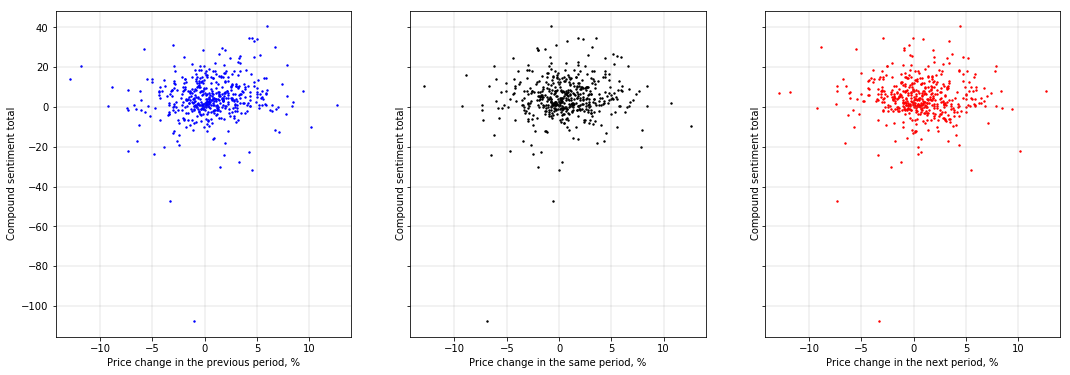

In [48]:
df = btc_twt

# fig, ax1 = plt.subplots(figsize=(8, 8))
fig, ((ax3, ax1, ax2)) = plt.subplots(1,3, sharex=True, sharey=True,figsize=(18, 6))

#Twitter variable
twt_var = "compound"
# axis label
twt_axis_label = dict(sent_diff = "Sentiment score change vs. past period",
                     compound = "Compound sentiment total")


ax1.scatter(df["price_change_pct"], df[twt_var], color="black",s=2)
ax1.set_xlabel('Price change in the same period, %')
ax1.set_ylabel(twt_axis_label[twt_var])
ax1.grid(color='grey', linestyle='-', linewidth=0.2)

ax2.scatter(df["price_change_pct_next_period"], df[twt_var], color="red",s=2)
ax2.set_xlabel('Price change in the next period, %')
ax2.set_ylabel(twt_axis_label[twt_var])
ax2.grid(color='grey', linestyle='-', linewidth=0.2)

ax3.scatter(df["price_change_pct_prev_period"], df["compound"], color="blue",s=2)
ax3.set_xlabel('Price change in the previous period, %')
ax3.set_ylabel(twt_axis_label[twt_var])
ax3.grid(color='grey', linestyle='-', linewidth=0.2)

plt.show()

### Check the correlations

In [49]:
correlations = btc_twt[["price_change_pct_prev_period","price_change_pct","price_change_pct_next_period",
         "sent_diff","compound","pos","neg"]].corr()

correlations.iloc[0:3,3:]

,sent_diff,compound,pos,neg
price_change_pct_prev_period,0.038357,0.107074,0.077613,-0.012525
price_change_pct,0.109802,0.091487,0.010327,-0.061251
price_change_pct_next_period,0.036790,0.003629,-0.018463,-0.019243


We can see that the highest correlations between the price variables and sentiment variables are achieved between:
  
* the compound sentiment in the current period and the price change vs. the past period (r = +0.164)
* the change in sentiment and the price change vs. the past period (r = +0.116)

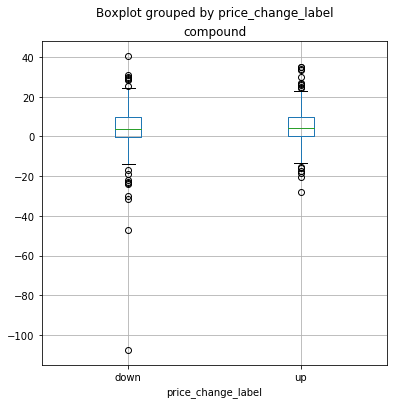

In [50]:
btc_twt.boxplot(column=twt_var,by='price_change_label',figsize=(6, 6))

### Next steps
  
Dima  
1. Get numeric feature for the price (rolling X hours) - daily and time-period (make function)

Liam
2. Get more Twitter data (to close the days with the gaps) - try switching off Top Tweets
3. Get more Twitter data - from "news" 

Tomorrow
4. Inspect correlations between sentiment and price response (also time-shifted)
5. Maybe - if we see correlation - come up with a model to predict the response

Optional
1. Word frequency distribution from the tweets (also separately for positive and negative tweets)

### Word Frequency Analysis

Look at high frequency words when the price differential is large, to see if the could be word usage signals to buy or sell.

In [51]:
# Get 1000 largest price differences since 2017/4/1
btc_large_diff = btc_ohlc[pd.to_datetime("2017-04-01").date():]
btc_large_diff["abs_price_change_pct"] = btc_large_diff["price_change_pct"].abs()
btc_large_diff = btc_large_diff.nlargest(100, "abs_price_change_pct")

#Get start time of time frame
btc_large_diff["timestart"] = [t.replace(tzinfo = None) for t in btc_large_diff.index]

In [52]:
btc_large_diff.head()

,open,high,low,close,median,price_change_label,price_change_pct,abs_price_change_pct,timestart
time_bracket,,,,,,,,,
2017-05-25 12:00:00-04:00,2686.02,2693.38,2221.00,2340.01,2398.99,down,-12.881885,12.881885,2017-05-25 12:00:00
2017-07-20 00:00:00-04:00,2324.99,2665.99,2303.20,2619.17,2529.00,up,12.652958,12.652958,2017-07-20 00:00:00
2017-11-30 00:00:00-05:00,10511.52,10581.95,9000.00,9273.72,9715.66,down,-11.775652,11.775652,2017-11-30 00:00:00
2017-12-06 12:00:00-05:00,12649.90,14095.00,12637.29,13999.00,13482.40,up,10.664906,10.664906,2017-12-06 12:00:00
2017-09-15 00:00:00-04:00,3359.95,3712.92,2972.01,3701.30,3267.13,up,10.159377,10.159377,2017-09-15 00:00:00


In [53]:
len(btc_ohlc_6h)

1025

In [54]:
twt_clean["future_price_diff"] = np.NaN

#Get future price change for respective tweet, if applicable
for t in twt_clean.index:
    if (btc_large_diff.timestart - twt_clean.date_time[t] <= pd.Timedelta('6 hours')).any():
        twt_clean["future_price_diff"][t] = btc_large_diff.price_change_pct[
            btc_large_diff.timestart - twt_clean.date_time[t] <= pd.Timedelta('6 hours')][0]

# Drop NaNs
twt_large_diff = twt_clean.dropna()

In [55]:
twt_large_diff.head()

,timestamp,tweet_proc,compound,neg,neu,pos,date_time,time_bracket,future_price_diff
3716,2017-05-03 18:00:40,"Bitcoin???168,000??????",0.0000,0.000,1.000,0.000,2017-05-03 18:00:40,2017-05-03 12:00:00-04:00,5.50413
3717,2017-05-03 18:01:48,WhatsAppDown but bitcoin going Up Up Up,0.0000,0.000,1.000,0.000,2017-05-03 18:01:48,2017-05-03 12:00:00-04:00,5.50413
3718,2017-05-03 18:18:05,Missing out on Bitcoin ? Price surges to all-t...,-0.2960,0.180,0.820,0.000,2017-05-03 18:18:05,2017-05-03 12:00:00-04:00,5.50413
3719,2017-05-03 18:26:52,"Exactly 2 ys old, ripe 4 update Argentina's ne...",0.4939,0.000,0.833,0.167,2017-05-03 18:26:52,2017-05-03 12:00:00-04:00,5.50413
3720,2017-05-03 19:05:10,Frenzy pushes bitcoin to all-time highs:,-0.3182,0.315,0.685,0.000,2017-05-03 19:05:10,2017-05-03 12:00:00-04:00,5.50413


In [56]:
len(twt_large_diff)

71622

We add domain-specific stop words to exclude from the frequency analysis (synonyms for "bitcoin" and the Twitter-specific term "RT" for retweet).

In [57]:
import nltk
from nltk.corpus import stopwords
from nltk.collocations import *

domain_stop_words = ["bitcoin","btc","blockchain","cryptocurrency","currency","new","digital","rt"]

stop_words = set(nltk.corpus.stopwords.words('german') +\
           nltk.corpus.stopwords.words('english') + domain_stop_words)

twt_diff_up = twt_large_diff[twt_large_diff.future_price_diff > 0]
twt_diff_down = twt_large_diff[twt_large_diff.future_price_diff < 0]

# Clean then tokenize tweets. Also, remove stop words
# For "up" related tweets

twt_tokens_up = [nltk.tokenize.word_tokenize(t)
              for t in twt_diff_up["tweet_proc"].str.lower().replace(r'[^a-z\s]+','',regex=True)]
vocab_up = [item for sublist in twt_tokens_up for item in sublist if item not in stop_words]
fdist_up = nltk.FreqDist(vocab_up)

# For "down" related tweets
twt_tokens_down = [nltk.tokenize.word_tokenize(t)
              for t in twt_diff_down["tweet_proc"].str.lower().replace(r'[^a-z\s]+','',regex=True)]
vocab_down = [item for sublist in twt_tokens_down for item in sublist if item not in stop_words]
fdist_down = nltk.FreqDist(vocab_down)

def top_bigrams(vocab,n):
    """
    Calculates the top n most frequent bigrams 
    in the vocabulary. Returns a sorted list with bigram and
    normalized frequency.
    """
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    word_fd = nltk.FreqDist(vocab)
    bigram_fd = nltk.FreqDist(nltk.bigrams(vocab))
    finder = BigramCollocationFinder(word_fd, bigram_fd)
    scored = finder.score_ngrams(bigram_measures.raw_freq)
    
    return([(" ".join(bigram),score) for bigram,score in scored[:n]])   

def make_freq_df(list_of_tuples):
    """Makes a Pandas DF from an output of FreqDist"""
    
    df = pd.DataFrame(list_of_tuples,columns=["token","frequency"])
    df["tf"] = df["frequency"]/df["frequency"].max()
    df["prob"] = df["frequency"]/df.shape[0]
    
    return(df)

In [58]:
# Need to normalize by vocab length or by the % of the maximum
print(len(twt_tokens_up), len(twt_tokens_down))

3681 67941


In [59]:
print(fdist_up.most_common(20),)

[('high', 293), ('first', 266), ('record', 260), ('time', 247), ('ethereum', 194), ('past', 190), ('price', 164), ('market', 138), ('alltime', 133), ('million', 125), ('surges', 119), ('could', 119), ('fintech', 117), ('soars', 116), ('worth', 110), ('news', 106), ('ransomware', 105), ('gold', 101), ('hits', 101), ('cnbc', 99)]


In [60]:
top_bigrams(vocab_up,10)

[('first time', 0.008955091545861596),
 ('alltime high', 0.005408520636609478),
 ('past first', 0.0045662100456621),
 ('record high', 0.004477545772930798),
 ('market cap', 0.0036795673183490714),
 ('fresh record', 0.002925921000132996),
 ('years ago', 0.0028372567274016934),
 ('feds kashkari', 0.0021279425455512702),
 ('surges record', 0.0020836104091856186),
 ('ago youd', 0.0019949461364543158)]

In [61]:
freq_up = make_freq_df(fdist_up.most_common())
freq_down = make_freq_df(fdist_down.most_common())

In [62]:
freq_up[:10]

,token,frequency,tf,prob
0,high,293,1.000000,0.061788
1,first,266,0.907850,0.056094
2,record,260,0.887372,0.054829
3,time,247,0.843003,0.052088
4,ethereum,194,0.662116,0.040911
5,past,190,0.648464,0.040067
6,price,164,0.559727,0.034585
7,market,138,0.470990,0.029102
8,alltime,133,0.453925,0.028047
9,million,125,0.426621,0.026360


In [63]:
freq_down[:10]

,token,frequency,tf,prob
0,ethereum,3473,1.000000,0.110820
1,says,2695,0.775986,0.085995
2,bubble,2531,0.728765,0.080762
3,price,2476,0.712928,0.079007
4,cryptocurrencies,2191,0.630867,0.069913
5,high,2118,0.609847,0.067584
6,could,2094,0.602937,0.066818
7,gold,2082,0.599482,0.066435
8,via,2078,0.598330,0.066307
9,crypto,2068,0.595451,0.065988


In [64]:
# Make a chart with top words associated with UP and DOWN

df1 = freq_up[:20].sort_values("prob",ascending=True)
df2 = freq_down[:20].sort_values("prob",ascending=True)
x = "prob"
y = "token"
text = x

trace1 = go.Bar(
            x=df1[x],
            y=df1[y],
            text= (df1[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(0,255,120,0.5)',
            ),
            orientation = 'h',
            name = "Price increased"
        )
trace2 = go.Bar(
            x=df2[x],
            y=df2[y],
            text=(df2[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(255,0,0,0.5)',
            ),
            orientation = 'h',
            name = "Price decreased"
        )

fig = tools.make_subplots(rows=1, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(height=600, width=900, title='Top terms associated with BTC price increase/decrease \
<br>(sorted by relative frequency of ocurrence in tweets)',
                     legend=dict(orientation="h"))
fig['layout']["yaxis1"].update(tickfont=dict(size=14))
fig['layout']["yaxis2"].update(tickfont=dict(size=14))

iplot(fig, filename='simple-subplot')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [65]:
# Make a chart with top bigrams
up_bigrams = make_freq_df(top_bigrams(vocab_up,20))
down_bigrams = make_freq_df(top_bigrams(vocab_down,20))

In [66]:
df1 = up_bigrams[:20].sort_values("frequency",ascending=True)
df2 = down_bigrams[:20].sort_values("frequency",ascending=True)
x = "frequency"
y = "token"
text = x

trace1 = go.Bar(
            x=df1[x],
            y=df1[y],
            text= (df1[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(0,255,120,0.5)',
            ),
            orientation = 'h',
            name = "Price increased"
        )
trace2 = go.Bar(
            x=df2[x],
            y=df2[y],
            text=(df2[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(255,0,0,0.5)',
            ),
            orientation = 'h',
            name = "Price decreased"
        )

fig = tools.make_subplots(rows=1, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(height=600, width=900, title='Top terms associated with BTC price increase/decrease\
<br>(sorted by relative frequency of ocurrence in tweets)',
                     legend=dict(orientation="h"),margin=dict(l=120))
fig['layout']["yaxis1"].update(tickfont=dict(size=14))
fig['layout']["yaxis2"].update(tickfont=dict(size=14))

iplot(fig, filename='simple-subplot')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### Reference

https://pandas.pydata.org/pandas-docs/stable/index.html  
http://mple.m-artwork.eu/tutorial  
Pandas Ifelse selection https://stackoverflow.com/a/19913845/8066374  
NLTK & Vader http://www.nltk.org/howto/sentiment.html  
Pandas dict to columns https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns  
Matplotlib multiple axes https://matplotlib.org/examples/api/two_scales.html  
Bigram analysis in NLTK http://www.nltk.org/howto/collocations.html  
Plotly Reference https://plot.ly/python/